In [16]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import anndata as ad
import seaborn as sns; sns.set(color_codes=True)
import stlearn as st
from matplotlib.colors import to_hex
from matplotlib import cm
import os
import re


# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

def filterAnndatas(adatas, channel_name='DAPI', DAPI_filter_val=10, fl_std_val=2, size_std_val=2, show_hist=True):
    for i in range(len(adatas)):
        # filter by DAPI
        print(f"Before DAPI filter: {len(adatas[i])}")
        adatas[i] = adatas[i][adatas[i][:, channel_name].X > DAPI_filter_val, :]
        print(f"After DAPI filter: {len(adatas[i])}")
        
        if show_hist:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
        
        # filter by fluorescence
        matrix = adatas[i].X
        cutoff_std_fl = np.mean(np.log(np.sum(matrix, axis=1))) - fl_std_val * (np.std(np.log(np.sum(matrix, axis=1))))
        if show_hist:
            ax1.hist(np.log(np.sum(matrix, axis=1)), bins=50, edgecolor='black')
            ax1.set_ylabel('Frequency')
            ax1.set_xlabel('Log Scaled Total Fluorescence Per Cell')
            ax1.axvline(x=cutoff_std_fl, color='red', linestyle='--')
            ax1.set_title('Fluorescence Distribution')
        idx = np.where(np.log(np.sum(matrix, axis=1)) > cutoff_std_fl)[0]
        adatas[i] = adatas[i][idx,:]

        # filter by cell size
        cellSizes = adatas[i].obs['cellSize'].values
        cutoff_std_size = np.mean(np.log(cellSizes)) + size_std_val * (np.std(np.log(cellSizes)))
        if show_hist:
            ax2.hist(np.log(cellSizes), bins=50, edgecolor='black')
            ax2.set_ylabel('Frequency')
            ax2.set_xlabel('Log Scaled Cell Sizes')
            ax2.axvline(x=cutoff_std_size, color='red', linestyle='--')
            ax2.set_title('Cell Size Distribution')
        idx = np.where(np.log(cellSizes) < cutoff_std_size)[0]
        adatas[i] = adatas[i][idx,:]

        if show_hist:
            plt.tight_layout()
            plt.show()

        st.pl.QC_plot(adatas[i])
    return adatas
# this function removes genes provided a list of gene names
def removeGenes(adatas, genes_to_remove=['DAPI']):
    for i in range(len(adatas)):
        adatas[i] = adatas[i][:,~adatas[i].var_names.isin(genes_to_remove)]
    return adatas
# this function performs CLR normalization on all adatas
def clrNormalizeAnndatas(adatas):
    for i in range(len(adatas)):
        clr_normalize_each_cell(adatas[i])
    return adatas
# this function merges the anndatas and save it as a h5ad for batch correction
def mergeNSave(adatas, file_name):
    adata = ad.concat(adatas, uns_merge='first')
    adata.write_h5ad(file_name+'.h5ad')

In [17]:
# loading and preprocessing
files = ['S17_7722_E4.txt','S1614455_C21.txt','S17_16194_A1.txt','S18_13562_A1.txt',
            'S18_5464_A1.txt','S18_13562_B1.txt','S17_10147B7_S2.txt',
            'US_15_18147_A1.txt','US17_14874-M5.txt','US_16_581_B6.txt',
            'US17_22972_A1.txt','US16-22209-1.txt','US17_1505-B5.txt',
            'US15_5145-1.txt','US15-9696-D7.txt']


In [18]:
adatas = []
for file in files:
    df = pd.read_csv(os.path.join('/mnt/scratch2/Luke/BrCa/Data/',file), sep='\t', lineterminator='\n')
    # df = pd.read_csv(file, sep='\t', lineterminator='\n')
    
    # Create the cell matrix
    # Match column names ending with ": Cell: Mean" or ": Mean"
    if any(df.columns.str.contains(r":\s?Cell:\sMean$")):
        # Prioritize "Cell: Mean"
        df_mat = df[df.columns[df.columns.str.contains(r":\s?Cell:\sMean$")]].copy()
        # Normalize column names by removing "Cell: " and ": Mean"
        df_mat.columns = df_mat.columns.str.replace(r":\s?Cell:\sMean$", '', regex=True)
    elif any(df.columns.str.contains(r":\s?Mean$")):
        # Fallback to ": Mean"
        df_mat = df[df.columns[df.columns.str.contains(r":\s?Mean$")]].copy()
        # Normalize column names by removing ": Mean"
        df_mat.columns = df_mat.columns.str.replace(r":\s?Mean$", '', regex=True)
    else:
        raise KeyError(f"No valid 'Cell: Mean' or ': Mean' columns found in file: {file}")
    
    # Adjust index to start from 1
    df_mat.index = df_mat.index + 1

    # Create the metadata file
    # Match column names for centroid and area, allowing for "Cell: " prefix or absence
    df_meta = df[[col for col in df.columns if re.search(r"(Centroid X µm|Centroid Y µm|Area µm²)$", col)]].copy()
    # Normalize metadata column names
    df_meta.columns = df_meta.columns.str.replace(r"Cell:\s", '', regex=True)
    # Adjust index to start from 1
    df_meta.index = df_meta.index + 1

    # Prepare spatial coordinates
    spatial = df_meta[['Centroid X µm', 'Centroid Y µm']].rename(
        columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'}
    )

    # Identify the appropriate "Area" column
    area_column = None
    if "Cell: Area µm^2" in df.columns:
        area_column = "Cell: Area µm^2"
    elif "Area µm^2" in df.columns:
        area_column = "Area µm^2"
    else:
        raise KeyError(f"No valid 'Area µm^2' or 'Cell: Area µm^2' column found in file: {file}")

    # Create stLearn AnnData object
    adata = st.create_stlearn(
        count=df_mat,
        spatial=spatial,
        library_id="Sample_test",
        scale=1,
        background_color="white"
    )

    # Add cell size as metadata
    adata.obs['cellSize'] = df[area_column].values
    adata.obs['batch'] = file.split('.')[0]
    print(adata)
    adatas.append(adata)


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1725589 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1495633 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 513798 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 900052 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 443740 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 534122 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1530319 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 240865 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1327094 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 530649 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 144686 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 349786 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1218835 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 938349 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 895487 × 66
    obs: 'imagecol', 'imagerow', 'cellSize', 'batch'
    uns: 'spatial'
    obsm: 'spatial'


In [19]:
gene_correction = pd.read_csv('CorrectedGenes1.csv')
# Iterate through the CSV file
for index, row in gene_correction.iterrows():
    file_path = row['FilePath']  # Path to the AnnData object file
    sample_name = row['Sample']  # Corresponding sample/batch name
    gene_name = row['Gene']  # Gene to update

    index = files.index(f"{sample_name}.txt")

    new_gene_values = pd.read_csv(file_path, sep='\t', lineterminator='\n')['ROI: 1.00 px per pixel: Channel 1: Mean'].values
    adatas[index][:,gene_name].X = new_gene_values

Before DAPI filter: 1725589
After DAPI filter: 1139410


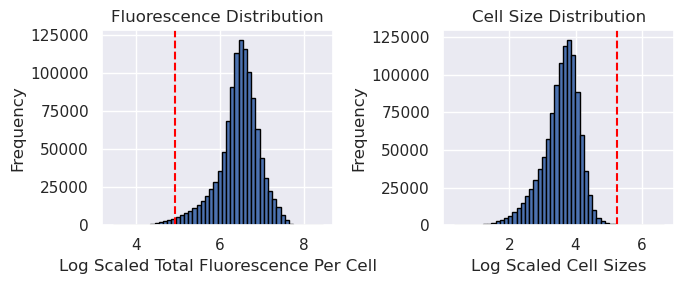

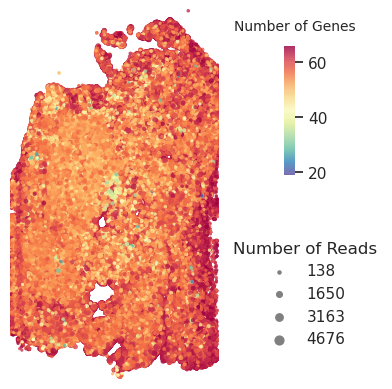

Before DAPI filter: 1495633
After DAPI filter: 1006737


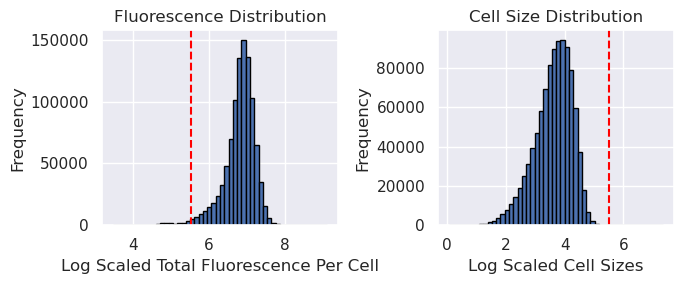

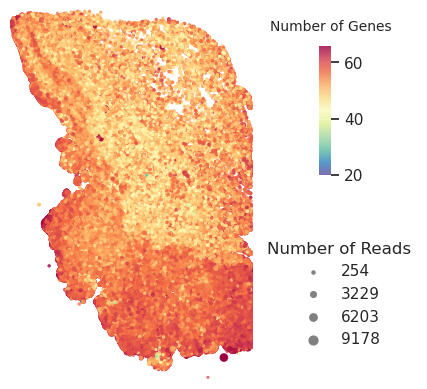

Before DAPI filter: 513798
After DAPI filter: 164318


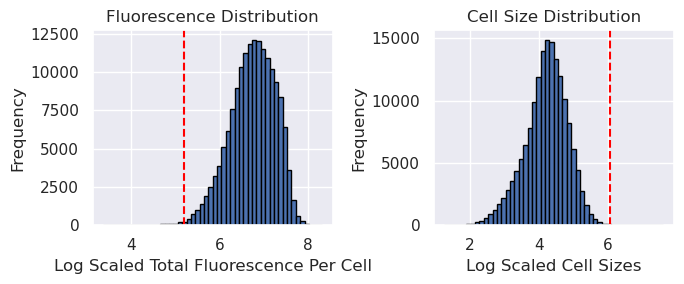

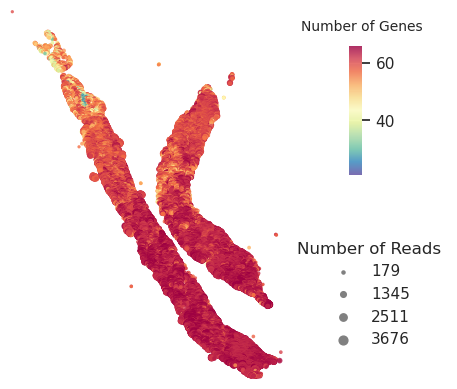

Before DAPI filter: 900052
After DAPI filter: 223771


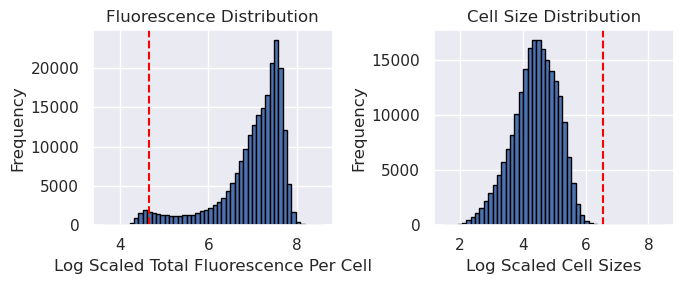

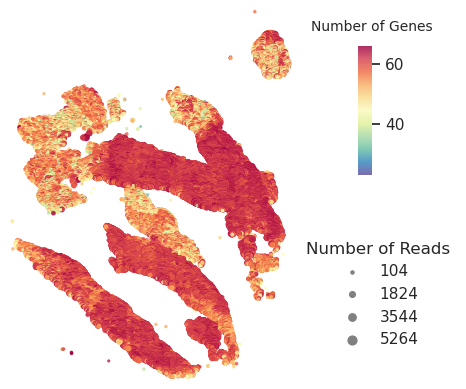

Before DAPI filter: 443740
After DAPI filter: 56041


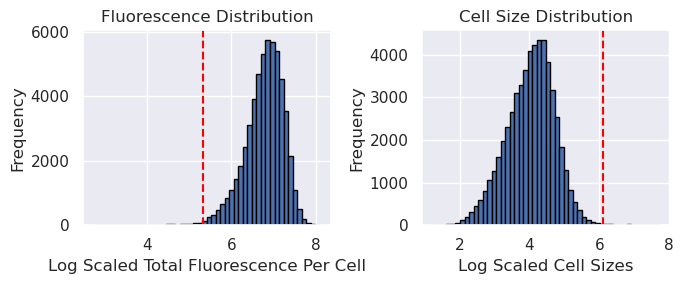

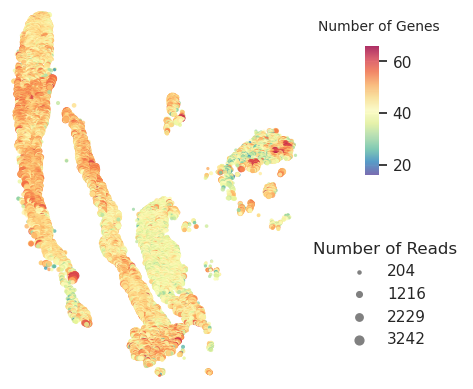

Before DAPI filter: 534122
After DAPI filter: 205572


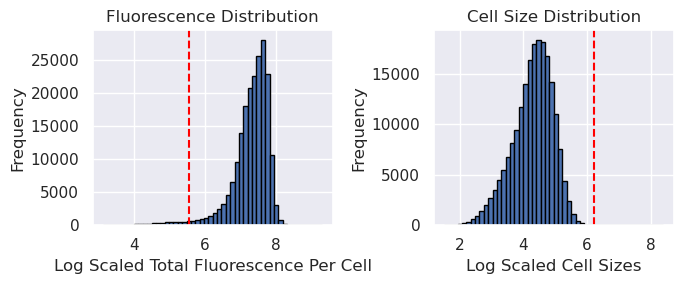

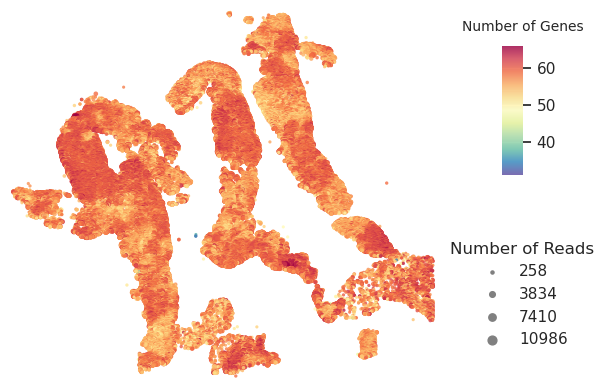

Before DAPI filter: 1530319
After DAPI filter: 980780


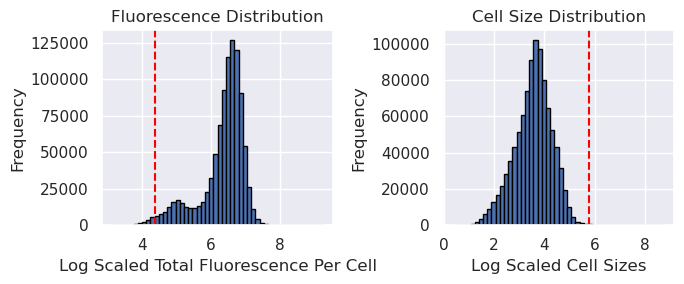

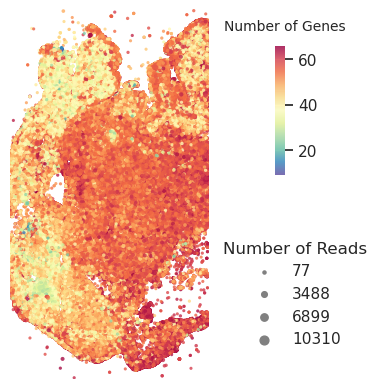

Before DAPI filter: 240865
After DAPI filter: 149166


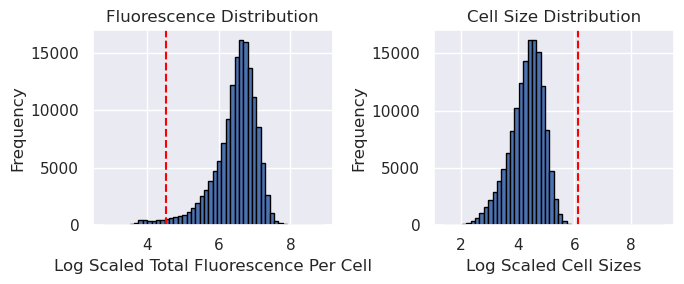

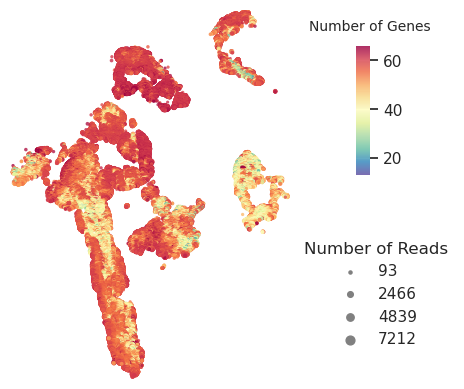

Before DAPI filter: 1327094
After DAPI filter: 1248499


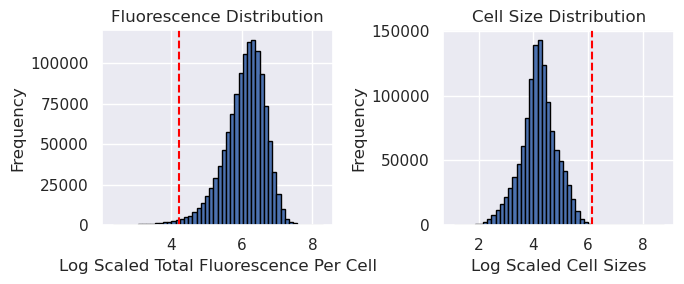

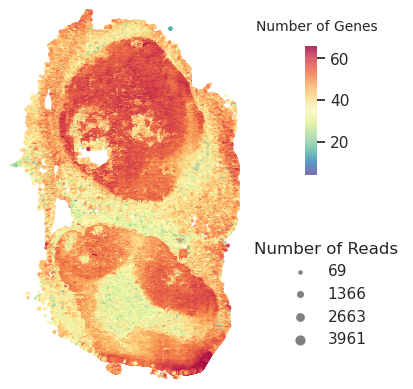

Before DAPI filter: 530649
After DAPI filter: 379344


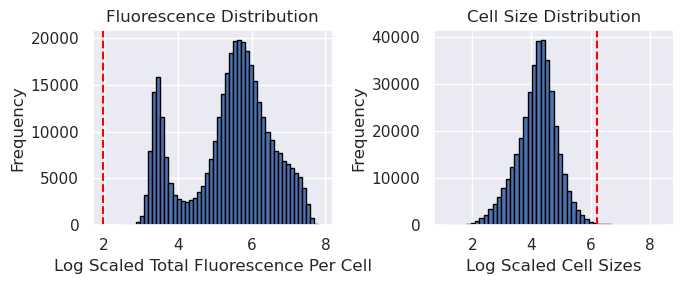

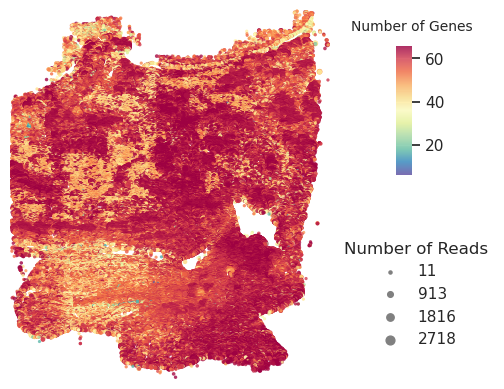

Before DAPI filter: 144686
After DAPI filter: 91853


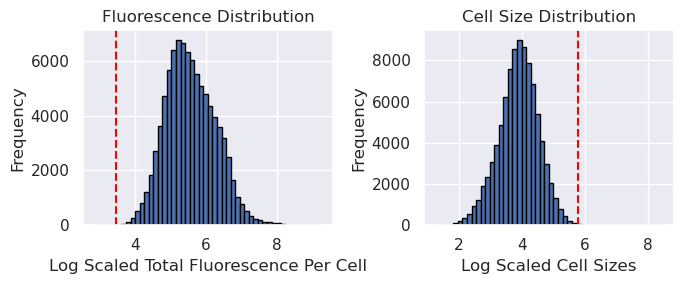

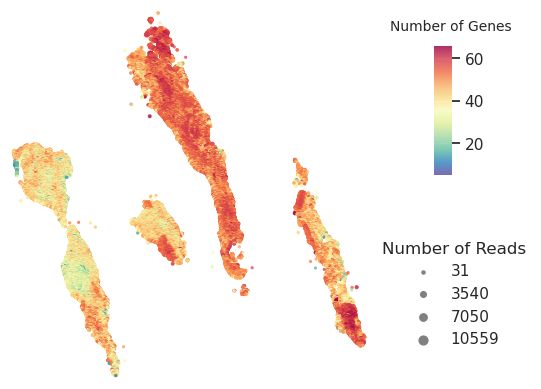

Before DAPI filter: 349786
After DAPI filter: 245429


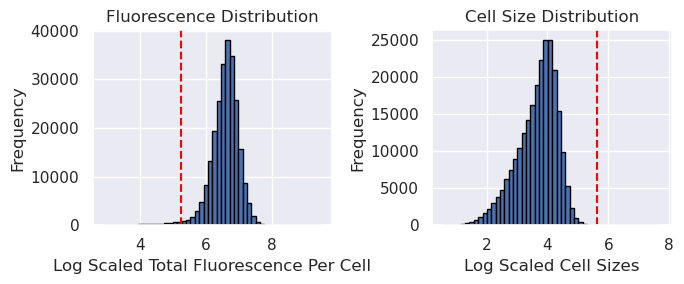

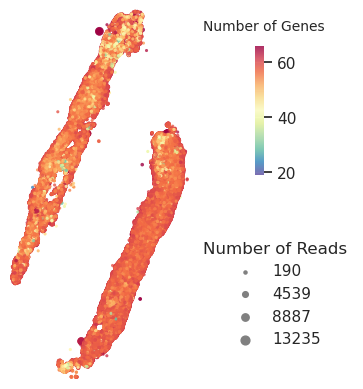

Before DAPI filter: 1218835
After DAPI filter: 1031914


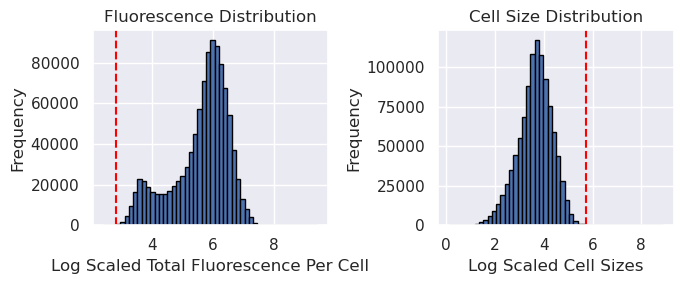

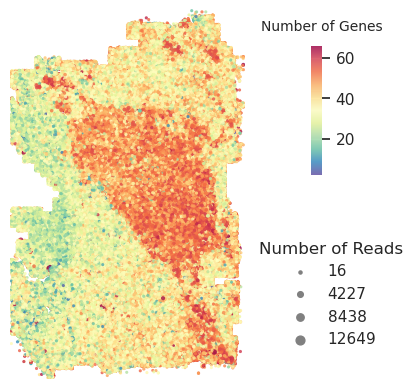

Before DAPI filter: 938349
After DAPI filter: 860427


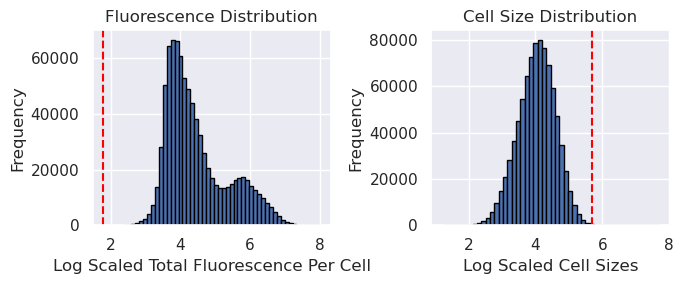

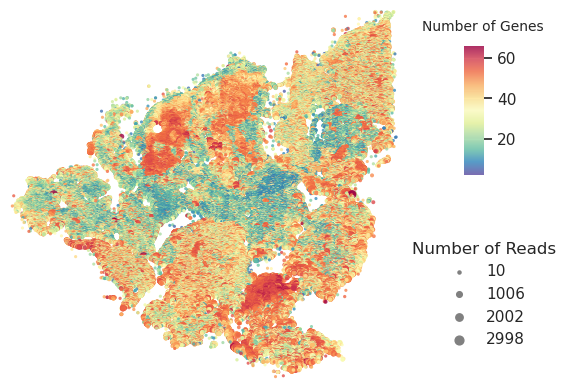

Before DAPI filter: 895487
After DAPI filter: 807391


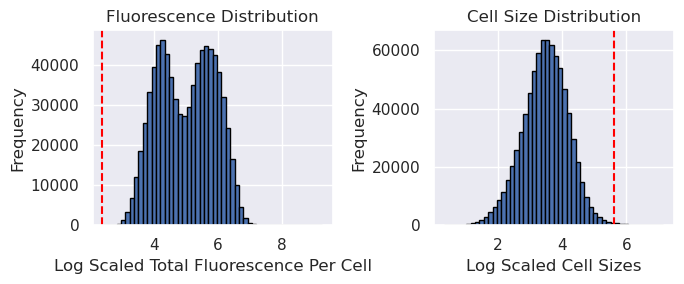

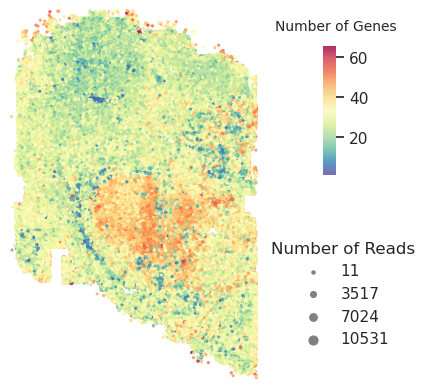

In [20]:
adatas = filterAnndatas(adatas, channel_name='DAPI', DAPI_filter_val=10, fl_std_val=3, size_std_val=3, show_hist=True)

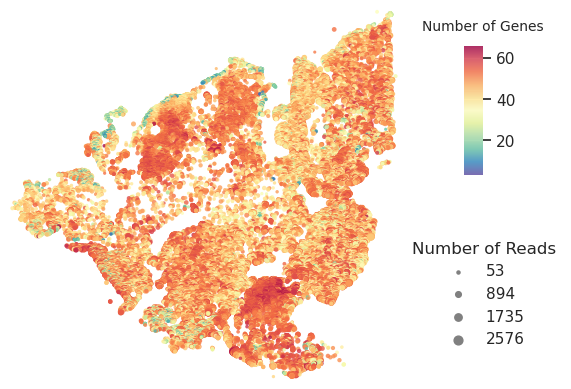

In [21]:
temp = adatas[-2].copy()
temp = temp[temp[:, 'DAPI'].X > 50, :]
st.pl.QC_plot(temp)

adatas[-2] = temp

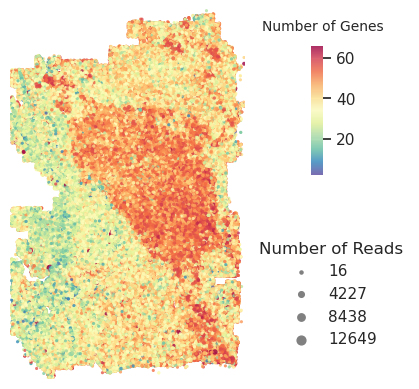

In [22]:
temp = adatas[-3].copy()
temp = temp[temp[:, 'DAPI'].X > 15, :]
st.pl.QC_plot(temp)

adatas[-3] = temp

In [23]:
adatas = removeGenes(adatas, genes_to_remove=['DAPI'])
# adatas = clrNormalizeAnndatas(adatas)

adata = ad.concat(adatas, uns_merge='first')
adata.obs.reset_index(drop=True, inplace=True)
adata.write_h5ad('adata.h5ad')

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
